# Customer Lifetime Value Prediction (Müşteri Yaşam Boyu Değeri Tahmini)

In [1]:
# Daha önceden CLTV hesaplaması yapılmıştı. Şu anda ise zaman projeksiyonlu olasılıksal lifetime value tahmini yapacağız.

CLTV = (**Customer Value** / Churn Rate)*Profit Margin

Customer Value = Average Order Value * Purchase Frequency

*Yukarıdaki formülleri bir önceki bölümden biliyoruz.*

In [2]:
# Bu bölümde yukarıdaki formüle başka bir bakış açısı getireceğiz.

# Customer Value = Purchase Frequency * Average Order Value
# CLTV= Expected Number of Transaciton * Expected Average Profit

**(Conditional) Expected Number of Transaciton**; bütün kitlenin satın alma davranışlarının olasılık dağılımı ile modellenmesi sonrasında, olasılık dağılımı ile modellediğimiz davranış biçimlerini koşullu (conditional) biçimde kişi özelinde biçimlendirerek, her bir kişi için beklenen işlem sayılarının tahmin edilmesidir. Zira müşterilerin genel bir satın alma davranışı bulunmaktadır. Genel satın alma davranışlarını bir olasılık dağılımı ile öğrendikten sonra (bir olasılıksal model kurduktan sonra), kişi özelinde o modelin özelliklerini biçimlendirerek beklenen satın alma sayılarını tahmin edeceğiz.

**(Conditional) Expected Average Profit**; bütün kitlenin average profit değerinin olasılıksal olarak modellenmesinden sonra modelin kullanımıyla kişi özelliklerinin girilmesiyle, kişi özelinde conditional expected average profitin ana kitlenin dağılımından beslenmiş bir şekilde hesaplanmasıdır.

In [3]:
# Yukarıda açıklanan CLTV prediction'ı için iki model kullanılacaktır.

# 1. BG/NBD Model
# 2. Gamma Gamma Submodel

# CLTV= Expected Number of Transaciton * Expected Average Profit
# CLTV = BG/NBD Model * Gamma Gamma Submodel

### BG/NBD Model (Beta Geometric / Negative Binominal Distribution ile Expected Number of Transaction)

BG/NBD Modeli satın alma/işlem sayısını tahmin etmek için kullanılan bir modeldir. Model süreci iki basamakta/başlıkta ele almaktadır.

Buy -> Till you Die

"Buy" kısmı satın alma bölümü, "Till you die" ise satın alımı bırakma bölümüdür.

**Transaction Process (Buy)**

1. Müşteri Alive oldugu sürece, belirli bir zaman periyodunda, müşteri tarafindan gerçeklestirilecek ișlem sayisi transaction rate parametresi ile poission dağılır.
2. Bir müsteri alive oldugu sürece kendi transaction rate'i etrafinda rastgele satin alma yapmaya devam edecektir.
3. Transaction rate'ler her bir müsteriye göre deisir ve tüm kitle için gamma dailir (r,a)

**Dropout Process (Till you die)**

1. Her bir müşterinin p olasiligi ile dropout rate (dropout probability)' vardir.
2. Bir müsteri alișveri yaptiktan sonra belirli bir olasilikla drop olur.
3. Dropout rate'ler her bir müsteriye göre değisir ve tüm kitle için beta dağilir (a,b)


### Gamma Gamma SubModel

Bir müşterinin işlem başına ortalama ne kadar kar getirebileceğini tahimn etmek için kullanılır.

* Bir müsterinin islemlerinin parasal degeri (monetary) transaction value'larinin ortalamasi etrafinda rastgele dağılır.
* Ortalama transaction value, zaman içinde kullanicilar arasinda degisebilir fakat tek bir kullanici için değişmez.
* Ortalama transaction value tüm müsteriler arasinda gamma dağılır.


In [4]:
# Yukarıda konunun teori kısmından biraz bahsettikten sonra aşağıdaki adımları izleyerek analizimizi tamamlayacağız;

# 1. Verinin Hazırlanması (Data Preperation)
# 2. BG-NBD Modeli ile Expected Number of Transaction
# 3. Gamma-Gamma Modeli ile Expected Average Profit
# 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
# 6. Çalışmanın fonksiyonlaştırılması

### 1. Verinin Hazırlanması (Data Preperation)

In [5]:
# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Veri Seti Hikayesi

# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.

In [8]:
# pip install lifetimes

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Analizimize başlamadan önce iki tane fonksiyon tanımlayacağız;

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Yukarıdaki fonksiyon ile değişkenimiz içerisindeki aykırı değerleri bulup onların remove edeceğiz.
# Aykırı değer; bir değişkenin genel dağılımının oldukça dışında olan değerlerdir.
# Örneğin yaş diye bir değişkenimiz olsun. Bu değişken için 80 değeri anlaşılabilir bir değerken 240 değeri aykırı bir değerdir.
# Bir yanlışlık olduğu çok bellidir. Yani bu değerin veri setinden kaldırılması gerekir.
# Sonuç olarak değişkenin içerisinde bulunan lakin değişkenin genel davranışının dışında olan değerleri baskılamak isteriz.

# Yukarıdaki fonksiyonda;
# İlk önce 1. çeyreklik daha sonra ise 3. çeyreklik hesaplanmıştır,
# Daha sonra çeyrekler açıklığı bulunmuştur,
# Üst limit olarak, 3. çeyrek + çeyrekler açıklığının 1.5 katı, alt limit olarak ise alt çeyrek - çeyrekler açıklığının 1.5 katı ile,
# alt ve üst limitler belirlenmiştir.

# DİKKAT !!! ".quantile()" metodu ile her ne kadar çeyrekler hesaplansa da yukarıda 0.01 (yüzde birlik) ve 0.99 (yüzde doksan dokuzluk)
# kısımlar hesaplanmıştır. Bunun sebebi verinin analiz edilirken analizi yapan kişinin yorumlamasından kaynaklanmaktadır.
# Analizi yapan kişi veriyi tanıyor ve çok fazla uç değer olmadığını düşünerek sadece biraz tıraşlamayı tercih etmektedir.
# Sonuç olarak bu fonsiyonun amacı dataframe üzerinde belirlediğimiz bir değişkenin eşik değerlerini bularak outlier (aykırı) değerleri
# baskılamaktır.

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Bir yukarıdaki fonksiyonda ise outlier (aykırı) değerlerin sınır değerler ile değiştirilmesi için bir fonksiyon yazılmıştır.
# İkinci satırda yorum satırı görmekteyiz, çünkü biz verimizi temizledikten sonra eksi değer olmayacağı için dolayısıyla, 
# aykırı değer de olmayacaktır.

In [10]:
yol = "datasets/online_retail_II.xlsx"

df_ = pd.read_excel(yol, sheet_name="Year 2010-2011")

df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
df.describe().T

# Aşağıda bakıldığında quantity ve price satırlarının minumum ve maksimum değerlerinin çok uçlarda olduğunu gözlemliyoruz.
# Bu çok uçlarda olmasını %25'lik ve %75'lik değerllerden anlıyoruz.
# Bunun pronlemlere sebep olacağını bildiğimiz için buralara müdahale edeceğiz.

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [12]:
df.shape

# Verinin kaç tane gözlemi var bakıyoruz.

(541910, 8)

In [13]:
df.isnull().sum()

# Verinin eksik değerlerine da bakıyoruz.
# Direk müşteriler üzerinden bir analiz yapacağımız için müşteri ID'si boş olan satırları sileceğiz.

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [14]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [15]:
# Silme sonrası bir kez daha describe metodunu çalıştırıyoruz.
df.describe().T

# Price değişkeninin minumum değerinin artık 0 olduğunu görüyorz.
# Ayrıca quantity ve price ortalamaları da değişmiştir.

# Burdan yola çıkarak şu yorumda bulunabiliriz, cutomer ID'deki eksik veriler bazı problemlere sebep olmuş gibi gözükmektedir.

,count,mean,std,min,25%,50%,75%,max
Quantity,406830.0,12.061276,248.693065,-80995.0,2.00,5.00,12.00,80995.0
Price,406830.0,3.460507,69.315080,0.0,1.25,1.95,3.75,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.0,13953.00,15152.00,16791.00,18287.0


In [16]:
# Invoice değişkeni içerisinde C ile başlayan değerler bu faturanın iade olduğu manasına gelmektedir.

df = df[~df["Invoice"].str.contains("C", na= False)]

In [17]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [18]:
df.describe().T

# Describe'a bir kez daha baktığımızda qunatity değişkenindeki eksi değerlerin de gittiğini görüyoruz. 
# Demek ki quantity'deki min değerin eksi olmasının sebebi iade faturalarmış.

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0,13.021793,180.419984,1.0,2.00,6.00,12.00,80995.00
Price,397925.0,3.116212,22.096773,0.0,1.25,1.95,3.75,8142.75
Customer ID,397925.0,15294.308601,1713.172738,12346.0,13969.00,15159.00,16795.00,18287.00


In [19]:
# quantity ve price'ın 0 (sıfır) olamayacağını düşünürsek,

df = df[df["Quantity"]>0]
df = df[df["Price"]>0]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [20]:
# Bir kez daha describe'ına baktığımızda;

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0,12.988208,179.331551,1.000,2.00,6.00,12.00,80995.00
Price,397885.0,3.116525,22.097861,0.001,1.25,1.95,3.75,8142.75
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


In [21]:
# Yukarıda gözlemlediğimiz üzere min değerler çözülmüş gibi dursa da max değerlerde hala outlier (aykırı) değerler var.
# Bu sorunu çözbilmek adına yukarıda tanımladığımız replace_with_tresholds() fonskiyonunu kullanacağız.

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df.describe().T

# Aşağıda artık maximumlar için de sorunun çözüldüğünü gözlemleyebiliyor,
# Hem ortalamalar da  değişimi gözlmeleyebiliyoruz hem de standart sapmalarda büyük ölçüde azalma gözlemliyoruz.

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0,11.830770,25.523052,1.000,2.00,6.00,12.00,298.50
Price,397885.0,2.893492,3.227175,0.001,1.25,1.95,3.75,37.06
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


In [22]:
# Totalprice sütunu oluşturalım;

df["TotalPrice"] = df["Quantity"] * df["Price"]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [23]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [24]:
# Analizi yaptığımız günü programa değişken olarak tanımlamamız gerekmektedir;

today_date = dt.datetime(2011, 12, 11)

### Lifetime Veri Yapısının Hazırlanması

In [25]:
# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# Buradaki recencty değeri müşterinin ilk satın alımı ile son satın alımı arasında geçen zamanı ifade etmektedir.
# 
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç (DİKKAT !!! Önceki notebooklar'da toplam kazançtı !!! Buradaki farka dikkat edelim.)

In [26]:
cltv_df = df.groupby("Customer ID").agg({
                                            "InvoiceDate" : [ lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                              lambda InvoiceDate: (today_date-InvoiceDate.min()).days],
                                            "Invoice"     :   lambda Invoice: Invoice.nunique(),
                                            "TotalPrice"  :   lambda TotalPrice: TotalPrice.sum()
})

cltv_df

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0               0        326        1     310.44
12347.0             365        368        7    4310.00
12348.0             282        359        4    1770.78
12349.0               0         19        1    1491.72
12350.0               0        311        1     331.46
...                 ...        ...      ...        ...
18280.0               0        278        1     180.60
18281.0               0        181        1      80.82
18282.0             118        127        2     178.05
18283.0             333        338       16    2094.88
18287.0             158        202        3    1837.28

[4338 rows x 4 columns]

In [27]:
# Aşağıdaki kod ile sütunların ilk başlığını siliyoruz,

cltv_df.columns = cltv_df.columns.droplevel(0)

# Daha sonrasında sütunlara yeni isim veriyoruz,

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

# Bir önceki aşamada monetary değerini sum() metodu ile hesaplamıştık, şimdi ise ortalamasını almamız gerekiyor,

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# Frequency değerinin 1'den büyük olması gerekiyor,

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

# Recency ve T sütunlarını haftalık olarak dönüştürmemiz gerekiyor,

cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

cltv_df


,recency,T,frequency,monetary
Customer ID,,,,
12347.0,52.142857,52.571429,7,615.714286
12348.0,40.285714,51.285714,4,442.695000
12352.0,37.142857,42.428571,8,219.542500
12356.0,43.142857,46.571429,3,937.143333
12358.0,21.285714,21.571429,2,575.210000
...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667
18273.0,36.428571,36.857143,3,68.000000
18282.0,16.857143,18.142857,2,89.025000


In [28]:
# Bir de describe'ına bakalım;

cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0,28.415064,16.266709,0.000000,14.000000,29.571429,42.714286,53.285714
T,2845.0,36.969169,14.712989,0.428571,27.428571,40.428571,51.285714,53.428571
frequency,2845.0,5.989104,9.044247,2.000000,2.000000,4.000000,6.000000,209.000000
monetary,2845.0,372.173563,349.301186,3.450000,191.073333,300.487308,436.870000,5724.302619


### 2. BG-NBD Modeli ile Expected Number of Transaction

In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
# BG-NBD Modelini yukarıdaki şekilde kuruyoruz. 
# "penalizer_coef" paramentresinin 0.001 seçilmesi ilerideki makine öğrenmesi derslerinde daha detaylı açıklanacaktır. 
# Yine de analizimiz devamlılık gösterecekse, yani aylık, 3 aylık 6 aylık süreçlerler yinelenecekse, 
# modelin teorsi üzerine daha fazla çalışma yapılmalıdır.

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

# Yukarıdaki kod bloğu ile de modelimizi fit ediyoruz.

# Aşağıdaki çıktıya görei modelimiz 2845 gözlem birimi üzeriden alpha, beta ve r değerleri için parametreleri buldu.

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [30]:
################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

bgf.conditional_expected_number_of_purchases_up_to_time(1,                      # Burada kaç haftalık istediğimizi belirtiyoruz.
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

# Aşağıda görüldüğü üzere 12748 ID no'lu müşteri önümüzdeki hafta 3.24 adet mal alma yapabilir beklentisindeyiz.
# Bütün data üzerinde bu 10 müşteriye bile odaklanılsa satışlar konusunda bir artış sağlanabilir.

Customer ID
12748.0    3.249532
14911.0    3.126418
17841.0    1.940152
13089.0    1.537420
14606.0    1.463897
15311.0    1.433618
12971.0    1.356931
14646.0    1.206361
13408.0    0.986184
18102.0    0.968542
dtype: float64

In [31]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

# Yukarıdaki metod ismi uzun geldiyse predict ile de çalıştırabiliriz.
# Lakin .predict() metodu Gamma Gamma modeli ile çalışmaz !!!

Customer ID
12748.0    3.249532
14911.0    3.126418
17841.0    1.940152
13089.0    1.537420
14606.0    1.463897
15311.0    1.433618
12971.0    1.356931
14646.0    1.206361
13408.0    0.986184
18102.0    0.968542
dtype: float64

In [32]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

# Yukarıdaki kod ile 1 hafta içerisinde satın alma potansiyeli olan kişilerin bilgilerini sütuna aktarıyoruz.
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0,52.142857,52.571429,7,615.714286,0.141281
12348.0,40.285714,51.285714,4,442.695000,0.091965
12352.0,37.142857,42.428571,8,219.542500,0.182390
12356.0,43.142857,46.571429,3,937.143333,0.086162
12358.0,21.285714,21.571429,2,575.210000,0.122256
...,...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667,0.172062
18273.0,36.428571,36.857143,3,68.000000,0.104342
18282.0,16.857143,18.142857,2,89.025000,0.135664


In [33]:
################################################################
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0,52.142857,52.571429,7,615.714286,0.141281,0.563508
12348.0,40.285714,51.285714,4,442.695000,0.091965,0.366759
12352.0,37.142857,42.428571,8,219.542500,0.182390,0.727104
12356.0,43.142857,46.571429,3,937.143333,0.086162,0.343520
12358.0,21.285714,21.571429,2,575.210000,0.122256,0.486227
...,...,...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667,0.172062,0.685560
18273.0,36.428571,36.857143,3,68.000000,0.104342,0.415740
18282.0,16.857143,18.142857,2,89.025000,0.135664,0.539214


In [34]:
# Bir ay içerisindeki potansiyel satışların hesaplanması

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1776.8934732202956

In [35]:
################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12347.0,52.142857,52.571429,7,615.714286,0.141281,0.563508,1.678373
12348.0,40.285714,51.285714,4,442.695000,0.091965,0.366759,1.092027
12352.0,37.142857,42.428571,8,219.542500,0.182390,0.727104,2.163054
12356.0,43.142857,46.571429,3,937.143333,0.086162,0.343520,1.022155
12358.0,21.285714,21.571429,2,575.210000,0.122256,0.486227,1.438787
...,...,...,...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667,0.172062,0.685560,2.036910
18273.0,36.428571,36.857143,3,68.000000,0.104342,0.415740,1.235225
18282.0,16.857143,18.142857,2,89.025000,0.135664,0.539214,1.593449


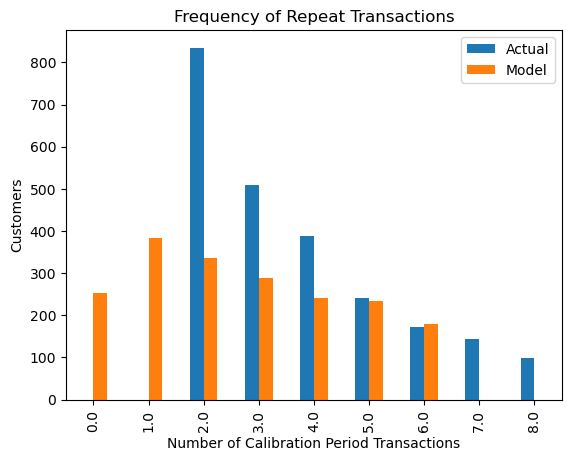

In [36]:
################################################################
# Model Çalışmasının Görselleştirilmesi ve Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()

# Modelin iyi çalıştığı ve çalışamadığı bölgeler vardır.
# Lakin detaylar makine öğrenmesi kısmında anlatılacaktır.

### 3. Gamma-Gamma Modeli ile Expected Average Profit

In [37]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

# ggf değişkeni ile model kurulaması gerektiğini söylüyoruz.
# "penalizer_coef" paramentresinin 0.01 seçilmesi ilerideki makine öğrenmesi derslerinde daha detaylı açıklanacaktır.

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

# Modeli kurduktan sonra, frequency ve monetary değerlerin göre fit ediyoruz.

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [38]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

# Yukardaki metod ile "Average Order Value" (koşullu beklenen ortalama kar değerlerinin "Aynı şeydir!") hesaplamasını yapıyoruz.

Customer ID
12347.0     631.912299
12348.0     463.745963
12352.0     224.886768
12356.0     995.998921
12358.0     631.902166
12359.0    1435.038544
12360.0     933.790539
12362.0     532.231834
12363.0     304.264346
12364.0     344.136967
dtype: float64

In [39]:
# Çoktan aza sıralmak istersek;

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12415.0    5772.178171
12590.0    5029.419619
12435.0    4288.944021
12409.0    3918.812814
14088.0    3917.129721
18102.0    3870.996931
12753.0    3678.578346
14646.0    3654.814813
15749.0    3216.052342
14096.0    3196.436057
dtype: float64

In [40]:
# Bu değerlerin sütun atamasını yapıyoruz,

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
                                                
cltv_df                                                

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12347.0,52.142857,52.571429,7,615.714286,0.141281,0.563508,1.678373,631.912299
12348.0,40.285714,51.285714,4,442.695000,0.091965,0.366759,1.092027,463.745963
12352.0,37.142857,42.428571,8,219.542500,0.182390,0.727104,2.163054,224.886768
12356.0,43.142857,46.571429,3,937.143333,0.086162,0.343520,1.022155,995.998921
12358.0,21.285714,21.571429,2,575.210000,0.122256,0.486227,1.438787,631.902166
...,...,...,...,...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667,0.172062,0.685560,2.036910,529.018453
18273.0,36.428571,36.857143,3,68.000000,0.104342,0.415740,1.235225,73.494233
18282.0,16.857143,18.142857,2,89.025000,0.135664,0.539214,1.593449,99.524928


In [41]:
# Bütün tabloyu "expected_average_profit"e göre sıralamak istersek;

cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0,44.714286,48.285714,21,5724.302619,0.379598,1.513895,4.507975,5772.178171
12590.0,0.000000,30.285714,2,4591.172500,0.011543,0.045961,0.136347,5029.419619
12435.0,26.857143,38.285714,2,3914.945000,0.076317,0.304084,0.903546,4288.944021
12409.0,14.714286,26.142857,3,3690.890000,0.117435,0.467409,1.385416,3918.812814
14088.0,44.571429,46.142857,13,3864.554615,0.260285,1.037908,3.089562,3917.129721
18102.0,52.285714,52.571429,60,3859.739083,0.968542,3.863599,11.511157,3870.996931
12753.0,48.428571,51.857143,6,3571.565000,0.126057,0.502762,1.497265,3678.578346
14646.0,50.428571,50.714286,73,3646.075685,1.206361,4.811915,14.333985,3654.814813
15749.0,13.857143,47.571429,3,3028.780000,0.027983,0.111573,0.332032,3216.052342


### 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması

In [42]:
# Yeni bir değişken ile CLTV'ye özel bir metod ile CLTV hesaplaması yapacağız,

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,              # 3 aylık
                                   freq="W",            # T'nin frekans bilgisi.
                                   discount_rate=0.01)  # # Discount Rate ise ileriki dönemlerde yapılabilecek indirimleri yansıtmaktadır.

cltv.head()                                   

Customer ID
12347.0    1128.447657
12348.0     538.808948
12352.0     517.500018
12356.0    1083.090254
12358.0     966.672697
Name: clv, dtype: float64

In [43]:
# Yukarıdaki çıktıda index sorunu vardır. Customer ID'ler index olarak gözükmektedir.
# Bu sorunu çözebilmek için,

cltv = cltv.reset_index()
cltv

# Görüldüğü üzere bizim CLTV olarak hesapladığımız değer clv sütununda hesaplanmıştır.

,Customer ID,clv
0,12347.0,1128.447657
1,12348.0,538.808948
2,12352.0,517.500018
3,12356.0,1083.090254
4,12358.0,966.672697
...,...,...
2840,18272.0,1146.205652
2841,18273.0,96.564818
2842,18282.0,168.594597
2843,18283.0,505.511694


In [44]:
# Şimdi ise bizim cltv_df ile cltv tablolarımmızı Customer ID üzerinden birleştirmemiz gerekmektedir.

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

# Left join ile birleştiriyoruz. Yani soladaki tablo bizim ana tablomuz olacaktır.

cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,73,3646.075685,1.206361,4.811915,14.333985,3654.814813,55741.084472
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968542,3.863599,11.511157,3870.996931,47412.580115
843,14096.0,13.857143,14.571429,17,3163.588235,0.728683,2.895541,8.552649,3196.436057,29061.661390
36,12415.0,44.714286,48.285714,21,5724.302619,0.379598,1.513895,4.507975,5772.178171,27685.100011
1257,14911.0,53.142857,53.428571,201,691.710100,3.126418,12.472198,37.164109,692.326367,27377.411521
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747427,2.981530,8.882986,2874.198684,27166.064343
874,14156.0,51.571429,53.142857,55,2104.026727,0.877495,3.500478,10.429815,2110.754226,23424.403180
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508821,2.029759,6.047649,2950.580133,18986.612337
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478052,1.906840,5.680124,2223.884974,13440.413085
650,13694.0,52.714286,53.428571,50,1275.700500,0.800803,3.194570,9.518559,1280.218258,12966.134702


### 5. CLTV'ye Göre Segmentlerin Oluşturulması

In [45]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0,52.142857,52.571429,7,615.714286,0.141281,0.563508,1.678373,631.912299,1128.447657,A
1,12348.0,40.285714,51.285714,4,442.695000,0.091965,0.366759,1.092027,463.745963,538.808948,B
2,12352.0,37.142857,42.428571,8,219.542500,0.182390,0.727104,2.163054,224.886768,517.500018,B
3,12356.0,43.142857,46.571429,3,937.143333,0.086162,0.343520,1.022155,995.998921,1083.090254,A
4,12358.0,21.285714,21.571429,2,575.210000,0.122256,0.486227,1.438787,631.902166,966.672697,A
...,...,...,...,...,...,...,...,...,...,...,...
2840,18272.0,34.857143,35.285714,6,513.096667,0.172062,0.685560,2.036910,529.018453,1146.205652,A
2841,18273.0,36.428571,36.857143,3,68.000000,0.104342,0.415740,1.235225,73.494233,96.564818,D
2842,18282.0,16.857143,18.142857,2,89.025000,0.135664,0.539214,1.593449,99.524928,168.594597,D
2843,18283.0,47.571429,48.285714,16,130.930000,0.301738,1.203356,3.583116,132.601228,505.511694,C


In [46]:
# İlk 50 gözleme bakaacak olursak,

cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0,50.428571,50.714286,73,3646.075685,1.206361,4.811915,14.333985,3654.814813,55741.084472,A
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968542,3.863599,11.511157,3870.996931,47412.580115,A
843,14096.0,13.857143,14.571429,17,3163.588235,0.728683,2.895541,8.552649,3196.436057,29061.661390,A
36,12415.0,44.714286,48.285714,21,5724.302619,0.379598,1.513895,4.507975,5772.178171,27685.100011,A
1257,14911.0,53.142857,53.428571,201,691.710100,3.126418,12.472198,37.164109,692.326367,27377.411521,A
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747427,2.981530,8.882986,2874.198684,27166.064343,A
874,14156.0,51.571429,53.142857,55,2104.026727,0.877495,3.500478,10.429815,2110.754226,23424.403180,A
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508821,2.029759,6.047649,2950.580133,18986.612337,A
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478052,1.906840,5.680124,2223.884974,13440.413085,A
650,13694.0,52.714286,53.428571,50,1275.700500,0.800803,3.194570,9.518559,1280.218258,12966.134702,A


In [47]:
pd.set_option('display.max_columns', None)

In [48]:
# Bütün segmentlerin özelliklerini görmek istersek,

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                           recency                \
              count         sum          mean   count           sum   
segment                                                               
D               712  11077635.0  15558.476124     712  15716.571429   
C               711  10885150.0  15309.634318     711  21806.142857   
B               711  10915854.0  15352.818565     711  20985.000000   
A               711  10627572.0  14947.358650     711  22333.142857   

                       T                          frequency                   \
              mean count           sum       mean     count   sum       mean   
segment                                                                        
D        22.073836   712  28811.000000  40.464888       712  2182   3.064607   
C        30.669681   711  27097.000000  38.111111       711  2912   4.095640   
B        29.514768   711  24751.142857  34.811734       711  3869   5.441632   
A        31.410890   711  24518.142857  34.484027       711  8076  11.358650   

        monetary                            expected_purc_1_week              \
           count            sum        mean                count         sum   
segment                                                                        
D            712  130981.712257  183.963079                  712   50.589776   
C            711  193174.984704  271.694775                  711   85.730876   
B            711  265517.631169  373.442519                  711  115.506578   
A            711  469159.458064  659.858591                  711  194.499324   

                  expected_purc_1_month                        \
             mean                 count         sum      mean   
segment                                                         
D        0.071053                   712  201.477446  0.282974   
C        0.120578                   711  341.393629  0.480160   
B        0.162457                   711  459.692623  0.646544   
A        0.273557                   711  774.329775  1.089071   

        expected_purc_3_month                        expected_average_profit  \
                        count          sum      mean                   count   
segment                                                                        
D                         712   598.090534  0.840015                     712   
C                         711  1013.217643  1.425060                     711   
B                         711  1362.659467  1.916539                     711   
A                         711  2297.144790  3.230865                     711   

                                     clv                             
                   sum        mean count           sum         mean  
segment                                                              
D        141999.665009  199.437732   712  1.020275e+05   143.297037  
C        206179.746147  289.985578   711  2.707430e+05   380.791852  
B        280058.943138  393.894435   711  4.893564e+05   688.264968  
A        487674.723941  685.899752   711  1.580098e+06  2222.359956

In [49]:
# Yukarıdaki son tabloda artık şunu yorumlamamız gerekiyor,
# Benim yeni müşteri bulmak için bir maliyetim var ve elimdeki müşteriler ise şu kadar potansiyel vaad ediyor, bunun kıyaslanması yapılmalıdır.

# Örneğin yeni müşteri bulmanın maaliyeti 30 birim olsun, elimdeki müşterinin potansiyel getirisi eğer ki;
# daha fazla ise elimdeki müşterilere odaklanmam gerekmektedir.
# daha az ise yeni müşteri bulma stratejileri geliştirilmelidir.